# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [ ]:
# Imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib
import PIL
from scipy import ndimage
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import os
from PIL import Image
import time


In [ ]:
# Parameters and Settings

TRAINING_MODE = False

TRAINED_MODEL_PATH = './lenet'
EPOCHS = 20
BATCH_SIZE = 128


training_file = "../german-traffic-signs-data/train.p"
validation_file= "../german-traffic-signs-data/valid.p"
testing_file = "../german-traffic-signs-data/test.p"

aug_training_file = "./new_train.p"
aug_validation_file = "./new_valid.p"

gaussain_blur_kernel_size = 1
rotation_angle = 15
minZoom = 0.9
maxZoom = 1.1
shift = 3

rate = 0.001

---
## Step 0: Load The Data

In [ ]:
# Load pickled data

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [579]:
#  Number of training examples
n_train = X_train.shape[0]

#  Number of testing examples.
n_test = X_test.shape[0]

#  What's the shape of an traffic sign image?
image_shape = X_train[0].shape

IMG_HEIGHT = X_train[0].shape[0]
IMG_WIDTH = X_train[0].shape[1]

#  How many unique classes/labels there are in the dataset.
classes, counts = np.unique(y_train, return_counts=True)
n_classes = len(classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 347990
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

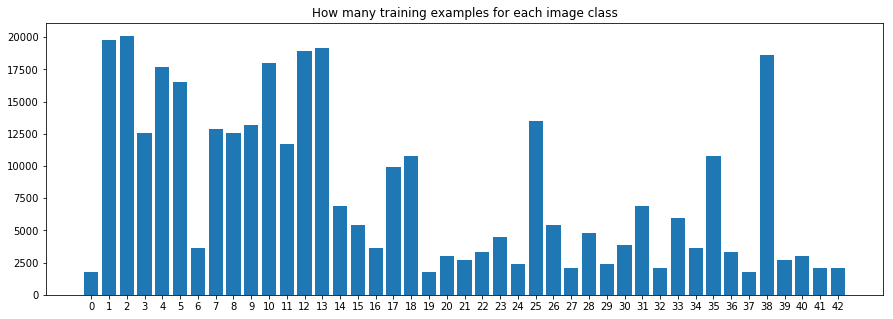

In [580]:
### Data exploration visualization code goes here.

# Visualizations will be shown in the notebook.
%matplotlib inline

plt.rcParams["figure.figsize"] = [15, 5]

plt.bar(classes,counts,tick_label=classes, align='center')

plt.title('How many training examples for each image class')

plt.show()

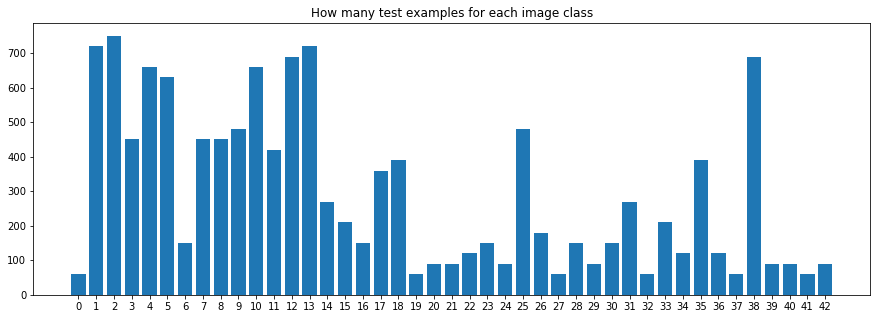

In [581]:
#  How many unique classes/labels there are in the dataset.
test_classes, test_counts = np.unique(y_test, return_counts=True)
n_test_classes = len(test_classes)

plt.rcParams["figure.figsize"] = [15, 5]

plt.bar(test_classes,test_counts,tick_label=test_classes, align='center')

plt.title('How many test examples for each image class')

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [582]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.

def rotate_random(img, angle):
    """Rotates image randomly between -angle and +angle"""
    rnd_angle = np.random.uniform(-angle, angle)
    return ndimage.rotate(img, rnd_angle,reshape=False)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return ndimage.gaussian_filter(np.array(img , dtype=float), kernel_size)

def zoom_random(img, minZoom, maxZoom):
    """Zooms an image """
    assert minZoom <= maxZoom, "minZoom must be less than or equal to maxZoom"
    zoom = np.random.uniform(minZoom, maxZoom)
    new_img = ndimage.zoom(img.reshape((32,32)), zoom)
    if (new_img.shape[0] <= img.shape[0] and new_img.shape[1] <= img.shape[1]):
        result = np.zeros(img.shape)
        result[:new_img.shape[0],:new_img.shape[1],:] = np.reshape(new_img, new_img.shape+(1,))
    else:
        result = np.reshape(new_img, new_img.shape+(1,))[:img.shape[0],:img.shape[1],:]
        
    return result

def shift_random(img, shift):
    """Translate image in x and y direction"""
    x_shift = np.random.uniform(-shift,shift)
    y_shift = np.random.uniform(-shift,shift)
    return ndimage.shift(img,(x_shift,y_shift,0))

# A weighted Average function to obtain the Grayscale value from RGB
# Formula: G = R*0.299 + G*0.587 + B*0.114
# Green is the most prominent color (nearly 60%), followed by red(30%) and finally blue(11%).
def weighted_average(pixel):
    return 0.299*pixel[0] + 0.587*pixel[1] + 0.114*pixel[2]

def rgb2gray(image):
    greyimg = np.zeros((image.shape[0], image.shape[1], 1))
    # get row number
    for rownum in range(len(image)):
        for colnum in range(len(image[rownum])):
            greyimg[rownum][colnum][0] = weighted_average(image[rownum][colnum])
    
    return greyimg

def transform_img(img, angle, blur_kernel_size, minZoom, maxZoom, shift):
    img_gray = rgb2gray(img)
    img_gray_blurred = gaussian_blur(img_gray, blur_kernel_size)
    
    img_gray_blurred_rotated1 = rotate_random(img_gray_blurred, angle)
    img_gray_blurred_rotated2 = rotate_random(img_gray_blurred, angle)
    
    img_gray_rotated1 = rotate_random(img_gray, angle)
    img_gray_rotated2 = rotate_random(img_gray, angle)
    
    img_gray_zoom1 = zoom_random(img_gray,minZoom, maxZoom)
    img_gray_zoom2 = zoom_random(img_gray,minZoom, maxZoom)
    
    img_gray_shifted1 = shift_random(img_gray, shift)
    img_gray_shifted2 = shift_random(img_gray, shift)
    
    return [img_gray,img_gray_blurred,img_gray_blurred_rotated1,
            img_gray_blurred_rotated2,img_gray_rotated1,img_gray_rotated2,
            img_gray_zoom1,img_gray_zoom2, img_gray_shifted1, img_gray_shifted2]


def transform_data(images,labels,rotation_angle,gaussain_blur_kernel_size, minZoom, maxZoom, shift):
    transformed_imgs = []
    for img in images:
        transformed_imgs += transform_img(img,rotation_angle,gaussain_blur_kernel_size, minZoom, maxZoom, shift)
    
    new_images = np.array(transformed_imgs)
    new_labels = np.array([[l,l,l,l,l,l,l,l,l,l] for l in labels]).flatten()
        
    return new_images, new_labels


if TRAINING_MODE:
    X_train, y_train = transform_data(X_train, y_train, rotation_angle,gaussain_blur_kernel_size, minZoom, maxZoom, shift)
    X_valid ,y_valid = transform_data(X_valid, y_valid, rotation_angle,gaussain_blur_kernel_size, minZoom, maxZoom, shift)
else: # restore augmented data set
    with open(aug_training_file, mode='rb') as f:
        train = pickle.load(f)
        print("loaded augmented training data from {}".format(aug_training_file))
    with open(aug_validation_file, mode='rb') as f:
        valid = pickle.load(f)
        print("loaded augmented validation data from {}".format(aug_validation_file))
        
    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']
    

print("Trainning data new size {} labels {}".format(X_train.shape, y_train.shape))
print("Validation data new size {} labels {}".format(X_valid.shape, y_valid.shape))
print("Testing data new size {} labels {}".format(X_test.shape, y_test.shape))

loaded augmented training data from ./new_train.p
loaded augmented validation data from ./new_valid.p
Trainning data new size (347990, 32, 32, 1) labels (347990,)
Validation data new size (44100, 32, 32, 1) labels (44100,)
Testing data new size (12630, 32, 32, 1) labels (12630,)


# Visualize the transformations done to a particular image


In [ ]:
if TRAINING_MODE: 
    # Making all the values of the images falls between -1 and 1. 
    X_train = X_train.astype('float32')
    X_train = (X_train - 128.) / 128.

    X_valid = X_valid.astype('float32')
    X_valid = (X_valid - 128.)/ 128.

    def save_augmented_data(file_name, features, labels):
        new_data = {'features': features, 'labels': labels}
        with open(file_name, mode='wb') as f:
            pickle.dump(new_data, f)
            print("saved new data to {} file.".format(file_name))

    save_augmented_data("new_train.p",X_train,y_train)
    save_augmented_data("new_valid.p",X_valid,y_valid)

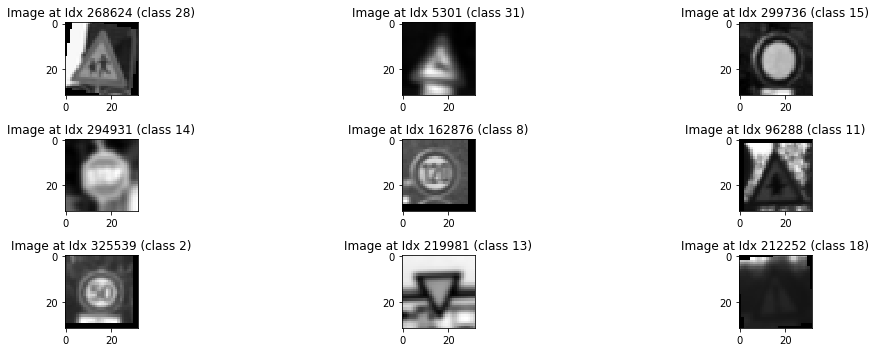

In [583]:
# Choose random training image and visually inspect transformed images

for i in range(9):
    rand_idx = np.random.randint(X_train.shape[0])
    image = X_train[rand_idx]
    plt.subplot(3, 3, i+1)
    plt.imshow(image.reshape((IMG_WIDTH,IMG_HEIGHT)), cmap='gray')
    plt.title('Image at Idx %d (class %d)' % (rand_idx,y_train[rand_idx]))

plt.tight_layout()
plt.show()

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #  Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x10.
    conv1_weights = tf.Variable(tf.truncated_normal(shape=(3,3,1,10), mean = mu, stddev = sigma))
    conv1_bias = tf.Variable(tf.zeros(10))
    
    conv1 = tf.nn.conv2d(x, conv1_weights,[1,1,1,1],padding='VALID') + conv1_bias

    #  Activation.
    conv1 = tf.nn.relu(conv1)
  
    #  Pooling. Input = 30x30x10. Output = 15x15x10.
    
    pool_layer1 = tf.nn.avg_pool(conv1,[1,2,2,1],[1,2,2,1],padding='VALID')

    #  Layer 2: Convolutional. Input= 15x15x10 Output = 10x10x32.
    conv2_weights = tf.Variable(tf.truncated_normal(shape=(5,5,10,32), mean = mu, stddev = sigma))
    conv2_bias = tf.Variable(tf.zeros(32))
    
    conv2 = tf.nn.conv2d(pool_layer1, conv2_weights,[1,1,1,1],padding='VALID') + conv2_bias

    #  Activation.
    conv2 = tf.nn.relu(conv2)

    #  Pooling. Input = 10x10x32. Output = 5x5x32.
    pool_layer2 = tf.nn.max_pool(conv2,[1,2,2,1],[1,2,2,1],padding='VALID')

    #  Flatten. Input = 5x5x32. Output = 800.
    flattened = flatten(pool_layer2)
    
    #  Layer 3: Fully Connected. Input = 800. Output = 400.
    fully_connected0_weights = tf.Variable(tf.truncated_normal(shape=(800,400), mean = mu, stddev = sigma))
    fully_connected0_bias = tf.Variable(tf.zeros(400))
    
    fully_connected0 = tf.matmul(flattened,fully_connected0_weights) + fully_connected0_bias
    
    #  Activation.
    fully_connected0 = tf.nn.relu(fully_connected0)
      
        
        
    # first dropout layer
    fully_connected0 = tf.nn.dropout(fully_connected0, keep_prob)

    
    
    #  Layer 4: Fully Connected. Input = 400. Output = 120.

    fully_connected1_weights = tf.Variable(tf.truncated_normal(shape=(400,120), mean = mu, stddev = sigma))
    fully_connected1_bias = tf.Variable(tf.zeros(120))
    
    fully_connected1 = tf.matmul(fully_connected0,fully_connected1_weights) + fully_connected1_bias
    
    #  Activation.
    fully_connected1 = tf.nn.relu(fully_connected1)
            
        
    # second dropout layer
    fully_connected1 = tf.nn.dropout(fully_connected1, keep_prob)


    #  Layer 5: Fully Connected. Input = 120. Output = 84.
    fully_connected2_weights = tf.Variable(tf.truncated_normal(shape=(120,84), mean = mu, stddev = sigma))
    fully_connected2_bias = tf.Variable(tf.zeros(84))
    
    fully_connected2 = tf.matmul(fully_connected1,fully_connected2_weights) + fully_connected2_bias
    
    #  Activation.
    fully_connected2 = tf.nn.relu(fully_connected2)

    #  Layer 5: Fully Connected. Input = 84. Output = Num of Classes.
    fully_connected3_weights = tf.Variable(tf.truncated_normal(shape=(84,n_classes), mean = mu, stddev = sigma))
    fully_connected3_bias = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fully_connected2,fully_connected3_weights) + fully_connected3_bias
    
    
    return logits, conv1, conv2, fully_connected0, fully_connected1, fully_connected2

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.

x = tf.placeholder(tf.float32, (None, IMG_WIDTH, IMG_HEIGHT, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) # probability to keep units

logits, conv1, conv2, fully_connected0, fully_connected1, fully_connected2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



    
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [ ]:
accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Num of examples {}".format(num_examples))
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        start_time = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        accuracy.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f} time taken: {:.2f} sec".format(validation_accuracy, time.time() - start_time))
        print()
        
    saver.save(sess, TRAINED_MODEL_PATH)
    print("Model saved")

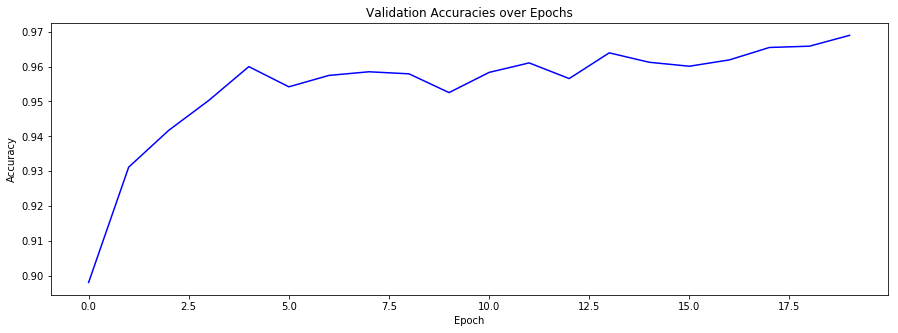

In [584]:
plt.plot(accuracy, 'b')  # training accuracy
plt.title('Validation Accuracies over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [585]:

with open("test_gray_normalized.p", mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test["features"], test["labels"]


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.970


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

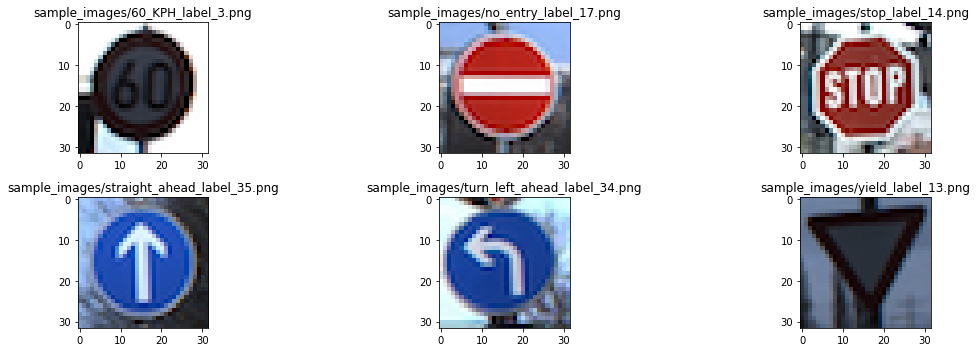

In [589]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
# Read sample image files, resize them, convert to numpy arrays w/ dtype=uint8


image_file_names = [image_file for image_file in os.listdir('sample_images')]
image_files  = ['sample_images/' + image_file for image_file in image_file_names]
images = []
image_labels = []
for i, image_file in enumerate(image_files):
    # ignoring .DS_store file/directory
    if image_file_names[i].startswith("."):
        continue
        
    # The class label is encoded as a string in the file name between the last underscore and the period.
    last_underscore_idx = image_file_names[i].rfind("_")
    period_idx = image_file_names[i].rfind(".")
    image_labels.append(int(image_file_names[i][last_underscore_idx+1: period_idx]))
    
    image = Image.open(image_file)
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title(image_file)
    
    image = image.convert('RGB')
    image = image.resize((IMG_HEIGHT, IMG_WIDTH), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))
    images.append(image)
    
images = np.array(images, dtype='uint8')
plt.tight_layout()
plt.show()

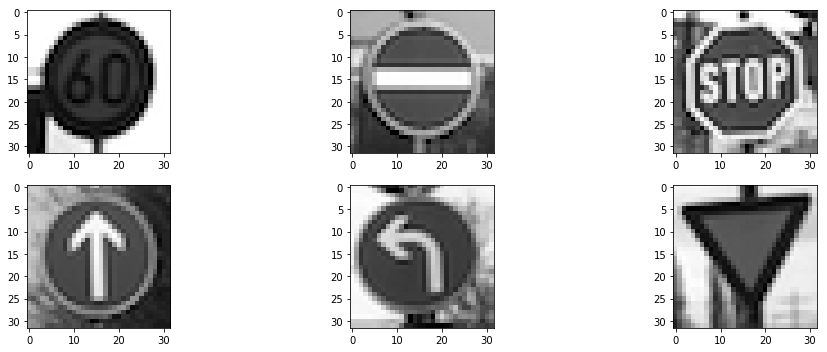

In [590]:
processed_sample_images = []
# Visually inspect sample images
for i, image in enumerate(images):
    image_gray = rgb2gray(image)
    image_gray = (image_gray - 128.)/ 128.
    processed_sample_images.append(image_gray)
    plt.subplot(2, 3, i+1)
    plt.imshow(image_gray.reshape((IMG_HEIGHT,IMG_WIDTH)), cmap='gray')

plt.tight_layout()
plt.show()

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predicted_logits = sess.run(logits, feed_dict={x:processed_sample_images, keep_prob:1.0})
    predictions = tf.argmax(predicted_logits,1)
    predictions = sess.run(predictions)
    # print the class labels of the predictions
    print(predictions)


### Analyze Performance

In [586]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

correct_predictions = np.array([1 if p == l else 0 for p,l in zip(predictions,image_labels)])
print("Prediction accuracy: {:.2f}%".format(correct_predictions.mean()*100))

Prediction accuracy: 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# Use top_k functions
with tf.Graph().as_default(), tf.Session() as sess:
#     logits = tf.placeholder('float', [None, n_classes])
#     softmax = tf.nn.softmax(logits)
    top_k_vals, top_k_idxs = sess.run(tf.nn.top_k(tf.nn.softmax(predicted_logits), k=5))

In [ ]:
# Load signnames.csv to map label number to sign string
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string

In [ ]:
def display_prediction_prob(idx):
    image = Image.open(image_files[idx])
    plt.imshow(image)
    
    labels = [label_map[top_k_idxs[idx][j]] for j in range(5)]
    probs = [top_k_vals[idx][j]*100 for j in range(5)]
    label_prob = zip(labels,probs)
    
    title = ""
    for l,p in label_prob:
        title = title + "{}:{}%\n".format(l.strip(),p)
    print(title)
    

Speed limit (60km/h):100.0%
No passing:2.5635735312334873e-06%
Speed limit (80km/h):1.8150420055818017e-07%
Speed limit (50km/h):5.1686777080561797e-08%
Turn right ahead:2.616262761989674e-08%



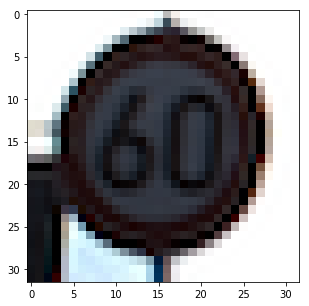

In [587]:
display_prediction_prob(0)

No entry:100.0%
Stop:4.37149610031253e-28%
No passing:5.977511098812214e-31%
Turn left ahead:4.267243960182559e-31%
Yield:3.4461358095362514e-31%



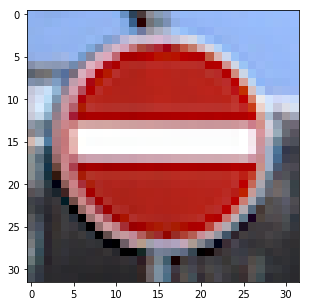

In [588]:
display_prediction_prob(1)

Stop:100.0%
Turn right ahead:2.9239657807348437e-13%
Speed limit (60km/h):5.056031211475832e-22%
No vehicles:4.267751696741968e-22%
Yield:4.908307343427108e-24%



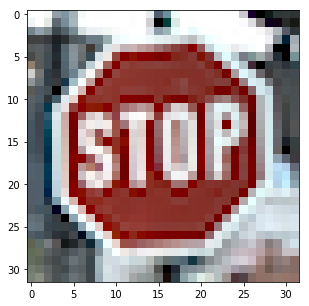

In [591]:
display_prediction_prob(2)

Ahead only:100.0%
Turn left ahead:2.6367685617773635e-22%
Turn right ahead:9.011243785703544e-24%
Go straight or left:1.6028951014847247e-24%
Children crossing:1.0197076831801269e-28%



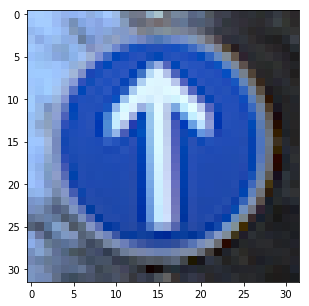

In [592]:
display_prediction_prob(3)

Turn left ahead:100.0%
Ahead only:4.054697929408574e-12%
Yield:4.473980712666176e-15%
Keep right:1.8192179903156287e-15%
Stop:6.215859052787383e-18%



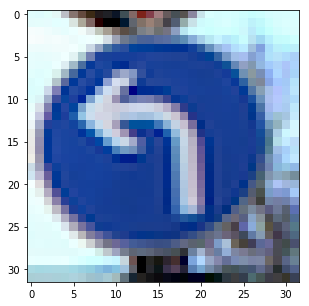

In [593]:
display_prediction_prob(4)

Yield:100.0%
Priority road:2.7112459450899355e-31%
Speed limit (20km/h):0.0%
Speed limit (30km/h):0.0%
Speed limit (50km/h):0.0%



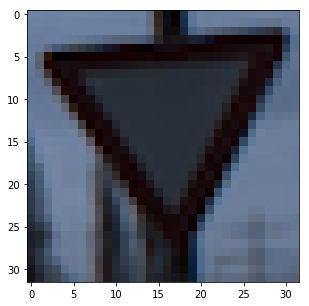

In [594]:
display_prediction_prob(5)

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:

#with tf.Graph().as_default(), tf.Session() as sess:
    
outputFeatureMap(processed_sample_images[0],conv1, plt_num=1)
outputFeatureMap(processed_sample_images[0],conv2, plt_num=2)
outputFeatureMap(processed_sample_images[0],fully_connected0, plt_num=3)
outputFeatureMap(processed_sample_images[0],fully_connected1, plt_num=4)
outputFeatureMap(processed_sample_images[0],fully_connected2, plt_num=5)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**
I wasn't able to get that part working, I kept getting errors.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 